In [61]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [62]:
def make_generator_network(
        input_size = 20,
        num_hidden_layers = 1,
        num_hidden_units = 100,
        num_output_units = 784):
    model = nn.Sequential()

    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
        model.add_module(f'relu_g{i}', nn.LeakyReLU())

        input_size = num_hidden_units

    model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('tanh_g', nn.Tanh())

    return model

In [64]:
def make_discriminator_network(
        input_size,
        num_hidden_layers = 1,
        num_hidden_units = 100,
        num_output_units = 1):
    model = nn.Sequential()

    for i in range(num_hidden_layers):
        model.add_module(
            f'fc_d{i}',
            nn.Linear(input_size, num_hidden_units, bias=False)
        )

        model.add_module(f'relu_d{i}', nn.LeakyReLU())
        model.add_module('dropout', nn.Dropout(p=0.5))
        
        input_size = num_hidden_units

    model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('sigmoid', nn.Sigmoid())

    return model

In [65]:
image_size = (28, 28)
z_size = 20

gen_hidden_layers = 1
gen_hidden_size = 100

disc_hidden_layers = 1
disc_hidden_size = 100

In [66]:
torch.manual_seed(1)

In [67]:
gen_model = make_generator_network(
    input_size = z_size,
    num_hidden_layers = gen_hidden_layers,
    num_hidden_units = gen_hidden_size,
    num_output_units = np.prod(image_size)
)

In [68]:
print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [69]:
disc_model = make_discriminator_network(
    input_size = np.prod(image_size),
    num_hidden_layers = disc_hidden_layers,
    num_hidden_units = disc_hidden_size
)

In [70]:
print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [72]:
import torchvision
from torchvision import transforms

In [73]:
image_path = './'

In [74]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

In [75]:
mnist_dataset = torchvision.datasets.MNIST(
    root = image_path, train = True, transform = transform, download=True
)

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 22826978.17it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 6733127.33it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 9727580.43it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 20684613.21it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [76]:
example, label = next(iter(mnist_dataset))

In [77]:
print(f'Min: {example.min()} Max: {example.max()}')

Min: -1.0 Max: 1.0


In [78]:
print(example.shape)

torch.Size([1, 28, 28])


In [79]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size) * 2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)

    return input_z

In [80]:
from torch.utils.data import DataLoader

In [81]:
batch_size = 32

In [82]:
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)

In [83]:
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)

In [84]:
torch.manual_seed(1)

In [85]:
mode_z = 'uniform'

In [86]:
input_z = create_noise(batch_size, z_size, mode_z)

In [87]:
print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])


In [88]:
g_output = gen_model(input_z)

In [89]:
print('Output of G -- shape:', g_output.shape)

Output of G -- shape: torch.Size([32, 784])


In [90]:
d_proba_real = disc_model(input_real)

In [91]:
d_proba_fake = disc_model(g_output)

In [92]:
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


In [93]:
loss_fn = nn.BCELoss()

In [94]:
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)

In [95]:
print(f'Generator Loss: {g_loss: .4f}')

Generator Loss:  0.6983


In [98]:
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)

In [99]:
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

In [100]:
print(f'Discriminator Losses: Real {d_loss_real: .4f} Fake {d_loss_fake: .4f}')

Discriminator Losses: Real  0.7479 Fake  0.6885


In [102]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)

In [103]:
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [104]:
gen_model = make_generator_network(
    input_size = z_size,
    num_hidden_layers = gen_hidden_layers,
    num_hidden_units = gen_hidden_size,
    num_output_units = np.prod(image_size)
).to(device)

In [105]:
disc_model = make_discriminator_network(
    input_size = np.prod(image_size),
    num_hidden_layers = disc_hidden_layers,
    num_hidden_units = disc_hidden_size
).to(device)

In [106]:
loss_fn = nn.BCELoss()

In [107]:
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [108]:
def d_train(x):
    disc_model.zero_grad()
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [116]:
def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [111]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

In [112]:
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))

    return (images + 1) / 2.0

In [113]:
epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []

In [114]:
num_epochs = 100

In [117]:
for epoch in range(1, num_epochs + 1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []

    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())

    print(f'Epoch {epoch: 03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]: .4f} / {all_d_losses[-1]: .4f}'
          f' [D-Real: {all_d_real[-1]: .4f}]'
          f' D-Fake: {all_d_fake[-1]: .4f}]')
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy()
    )

Epoch  01 | Avg Losses >> G/D  0.8893 /  0.9306 [D-Real:  0.7886] D-Fake:  0.4738]
Epoch  02 | Avg Losses >> G/D  0.9042 /  1.1878 [D-Real:  0.5966] D-Fake:  0.4512]
Epoch  03 | Avg Losses >> G/D  0.9563 /  1.1651 [D-Real:  0.5921] D-Fake:  0.4172]
Epoch  04 | Avg Losses >> G/D  1.0393 /  1.1452 [D-Real:  0.6001] D-Fake:  0.4032]
Epoch  05 | Avg Losses >> G/D  0.9565 /  1.2110 [D-Real:  0.5793] D-Fake:  0.4246]
Epoch  06 | Avg Losses >> G/D  0.9620 /  1.2094 [D-Real:  0.5754] D-Fake:  0.4193]
Epoch  07 | Avg Losses >> G/D  0.9357 /  1.2218 [D-Real:  0.5732] D-Fake:  0.4229]
Epoch  08 | Avg Losses >> G/D  0.9187 /  1.2364 [D-Real:  0.5644] D-Fake:  0.4311]
Epoch  09 | Avg Losses >> G/D  0.9129 /  1.2407 [D-Real:  0.5674] D-Fake:  0.4322]
Epoch  10 | Avg Losses >> G/D  0.9990 /  1.2016 [D-Real:  0.5822] D-Fake:  0.4155]
Epoch  11 | Avg Losses >> G/D  0.9442 /  1.2134 [D-Real:  0.5797] D-Fake:  0.4252]
Epoch  12 | Avg Losses >> G/D  0.9240 /  1.2386 [D-Real:  0.5685] D-Fake:  0.4328]
Epoc

In [118]:
import itertools

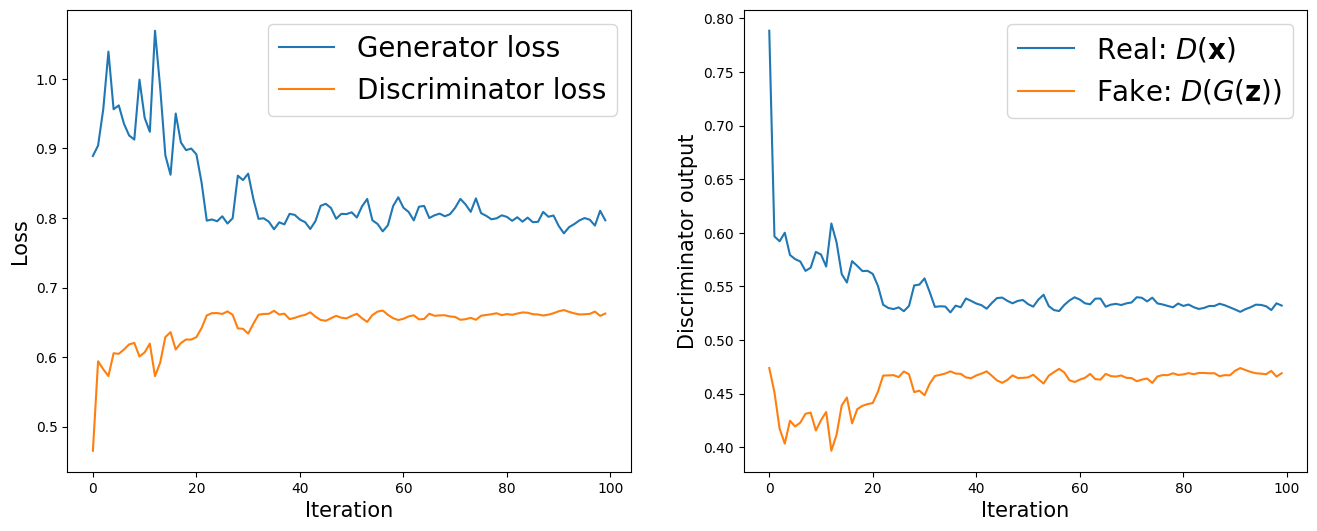

In [119]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator loss')

half_d_losses = [all_d_loss / 2 for all_d_loss in all_d_losses]

plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)

ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)

ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

plt.show()

In [120]:
selected_epochs = [1, 2, 4, 10, 50, 100]

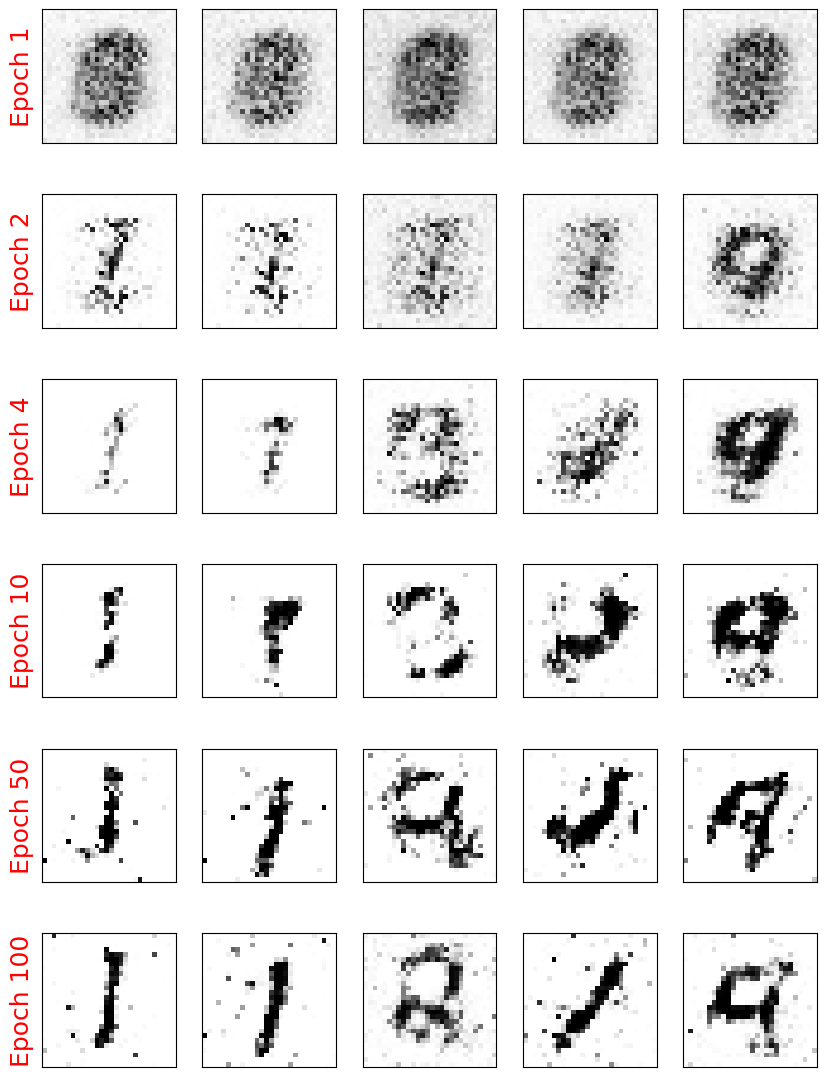

In [121]:
fig = plt.figure(figsize=(10, 14))

for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        
        ax.set_xticks([])
        ax.set_yticks([])

        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes
            )

        image = epoch_samples[e - 1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()